In [2]:
#!pip install pandas_datareader

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 109 kB 1.7 MB/s            
     |████████████████████████████████| 6.4 MB 270 kB/s            


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [11]:
#amazon ticker symbol Alibaba=BABA
company = 'NDX'
start = dt.datetime(2012,1,1)
end = dt.datetime(2020,12,31)

data=web.DataReader(company,'yahoo',start,end)

#Prepare data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60

x_train=[]
y_train=[]

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x,0])
    y_train.append(scaled_data[x,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
model=Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #Prediction of the next closing values
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
69/69 [==============================] - 12s 78ms/step - loss: 0.0268
Epoch 2/25
69/69 [==============================] - 4s 60ms/step - loss: 0.0020
Epoch 3/25
69/69 [==============================] - 4s 61ms/step - loss: 0.0015
Epoch 4/25
69/69 [==============================] - 4s 60ms/step - loss: 0.0018
Epoch 5/25
69/69 [==============================] - 4s 60ms/step - loss: 0.0014
Epoch 6/25
69/69 [==============================] - 4s 60ms/step - loss: 0.0015
Epoch 7/25
69/69 [==============================] - 4s 64ms/step - loss: 0.0014
Epoch 8/25
69/69 [==============================] - 4s 61ms/step - loss: 0.0015
Epoch 9/25
69/69 [==============================] - 4s 64ms/step - loss: 0.0014
Epoch 10/25
69/69 [==============================] - 4s 60ms/step - loss: 0.0012
Epoch 11/25
69/69 [==============================] - 4s 63ms/step - loss: 0.0013
Epoch 12/25
69/69 [==============================] - 4s 62ms/step - loss: 0.0013
Epoch 13/25
69/69 [=================

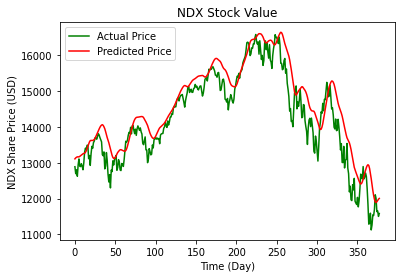

In [14]:
#Test
test_start = dt.datetime(2021,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
                    
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

plt.plot(actual_prices, color="green", label="Actual Price")
plt.plot(predicted_prices, color="red", label="Predicted Price")
plt.title(f"{company} Stock Value")
plt.xlabel('Time (Day)')
plt.ylabel(f"{company} Share Price (USD)")
plt.legend()
plt.show()

In [15]:
#Predict Next Day
real_data = [model_inputs[len(model_inputs)+1-prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: [[12015.513]]


[11954.9795, 11970.868, 11995.749, 12029.586, 12070.642, 12116.799, 12166.215, 12217.534, 12269.877, 12322.738, 12375.875, 12429.197, 12482.708, 12536.438, 12590.44, 12644.758, 12699.434, 12754.501, 12809.984, 12865.907, 12922.285, 12979.137, 13036.474, 13094.303, 13152.645, 13211.494, 13270.87, 13330.774, 13391.213, 13452.187, 13513.709, 13575.775, 13638.388, 13701.554, 13765.271, 13829.544, 13894.368, 13959.748, 14025.684, 14092.174, 14159.218, 14226.815, 14294.969, 14363.669, 14432.921, 14502.722, 14573.067, 14643.956, 14715.386, 14787.35, 14859.847, 14932.87, 15006.421, 15080.487, 15155.072, 15230.165, 15305.756, 15381.847, 15458.421, 15535.48, 15613.014, 15691.007, 15769.46, 15848.358, 15927.689, 16007.45, 16087.628, 16168.206, 16249.178, 16330.522, 16412.238, 16494.3, 16576.705, 16659.453, 16743.195, 16827.361, 16911.97, 16997.043, 17082.596, 17168.637, 17255.18, 17342.227, 17429.781, 17517.848, 17606.43, 17695.531, 17785.152, 17875.299, 17965.967, 18057.174, 18148.906, 18241.18,

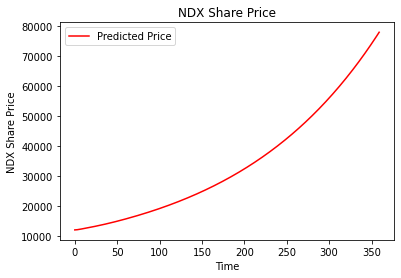

In [16]:
#Prediction for next 60days
df=web.DataReader(company,'yahoo',dt.datetime(2012,1,1),dt.datetime.now())
first=True
results=[]

#Prepare data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(df['Close'].values.reshape(-1,1))

for i in range(360):
    if first:
        first=False
    else:
        df = df.append({'Close': prediction[0][0]}, ignore_index=True)
        scaled_df = scaler.fit_transform(df['Close'].values.reshape(-1,1))
        
    real_data=[scaled_df[len(scaled_df)-prediction_days:,0]]
    real_data = np.array(real_data)
    real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))
    prediction = model.predict(real_data)
    prediction = scaler.inverse_transform(prediction)
    results.append(prediction[0][0])

print(results)
plt.plot(results, color="red", label="Predicted Price")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.show()